# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [97]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from IPython.display import Image  
from sklearn import tree
import pydotplus

In [98]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [99]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [100]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [101]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [102]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [103]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [104]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [105]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [106]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [107]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [108]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [109]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [110]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [111]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [112]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [113]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [114]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [115]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [116]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [117]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [118]:
# Combining all the above students 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:42<00:00, 1635.25it/s]


In [119]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [120]:
ln = (len(preprocessed_reviews))

In [121]:
final['preprocessed_text']=preprocessed_reviews

In [122]:
#calculating the number of words in each review
length = []
for i in range(len(preprocessed_reviews)):
    length.append(len(preprocessed_reviews[i].split()))
final['length_of_text']=length

### Preparing datasets

In [123]:
#splitting data evenly to avoid imbalance data

positive_data = final[final["Score"] == 1].sample(n = 50000)
negative_data = final[final["Score"] == 0].sample(n = 50000)
new_final = pd.concat([positive_data, negative_data])
new_final.shape

(100000, 12)

In [124]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
#conversion of Unix time
new_final["Time"] = pd.to_datetime(new_final["Time"], unit = "s")
new_final = new_final.sort_values(by = "Time")

In [125]:
new_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,length_of_text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,32
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...,32
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,31
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,39
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,recently purchased woodstream corp gopher trap...,44


In [126]:
#converting the dataframe to array
# x contains all reviews
# y contains its corresponding class labels
x = new_final['preprocessed_text'].values
y = new_final['Score'].values
print(y.shape)
print(type(y))
print(x.shape)
print(type(x))


(100000,)
<class 'numpy.ndarray'>
(100000,)
<class 'numpy.ndarray'>


### Splitting Data

In [127]:
# Splitting x and y (total data) for x1,y1 and xTest, yTest
x1 = x[:75000]
y1 = y[:75000]
xTest = x[75000:]
yTest = y[75000:]

# Splitting x1 and y2 for xCV,yCV and xTrain, yTrain
xTrain = x1[:56200]
yTrain = y1[:56200]
xCV = x1[56200:]
yCV = y1[56200:]

In [128]:

print("Shape of Train data "+ str(xTrain.shape), str(yTrain.shape))
print("Shape of Test data "+ str(xTest.shape), str(yTest.shape))
print("Shape of Cross Validation data "+ str(xCV.shape), str(yCV.shape))

Shape of Train data (56200,) (56200,)
Shape of Test data (25000,) (25000,)
Shape of Cross Validation data (18800,) (18800,)


In [129]:
# frequency count of number of positive and negative values in Train data
# source: https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-94.php
print(type(yTrain))
unique_elements, counts_elements = np.unique(yTrain, return_counts=True)
print("Number of positive and negative values in Train data")
print(np.asarray((unique_elements, counts_elements)))

<class 'numpy.ndarray'>
Number of positive and negative values in Train data
[[    0     1]
 [26717 29483]]


# [5] Assignment 8: Decision Trees


<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees on BOW,<font color='red'> SET 1</font>

### 1. Bag of Words Vectorization

In [130]:
#Bag of Words

count_vect = CountVectorizer(min_df = 10, max_features=500)
count_vect.fit(xTrain)
xTrain_bow=count_vect.transform(xTrain)
xCV_bow=count_vect.transform(xCV)
xTest_bow=count_vect.transform(xTest)
print("After transform")
print('='*100)
print("Train Data")
print(xTrain_bow.shape, yTrain.shape)
print("Cross Validation Data")
print(xCV_bow.shape, yCV.shape)
print("Test Data")
print(xTest_bow.shape, yTest.shape)
print('='*100)

After transform
Train Data
(56200, 500) (56200,)
Cross Validation Data
(18800, 500) (18800,)
Test Data
(25000, 500) (25000,)


In [131]:
# Please write all the code with proper documentation

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

AUC_BOW_Train = []
AUC_BOW_CV = []

depth = [1, 5, 10, 50, 100, 500, 1000]
split = [5, 10, 50, 100, 500] 

# Decision Tree
for i in tqdm(depth):
    for j in split:
        clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        clf.fit(xTrain_bow, yTrain)

        #Predicting probability of positive class
        #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
        #we are slicing 2nd value
        Y_train_pred =  clf.predict_proba(xTrain_bow)[:,1]
        Y_cv_pred =  clf.predict_proba(xCV_bow)[:,1]
    
        #Calculation of ROC-AUC score on both train and-cross validate data
        AUC_BOW_Train.append(roc_auc_score(yTrain,Y_train_pred))
        AUC_BOW_CV.append(roc_auc_score(yCV, Y_cv_pred))



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:41<00:00, 77.59s/it]


In [132]:
print(AUC_BOW_Train)

[0.6173362708102478, 0.6173362708102478, 0.6173362708102478, 0.6173362708102478, 0.6173362708102478, 0.7405571973572473, 0.7405571973572473, 0.7403570176717287, 0.7402236580695908, 0.7398561964876379, 0.8154997199171601, 0.8149485824511086, 0.8097384891288525, 0.8074550561719513, 0.8014788944734637, 0.9852180192348021, 0.9781044580714583, 0.946026384873618, 0.9229980696227107, 0.8715536588901722, 0.9972900421644324, 0.9915848671724106, 0.9615225466981441, 0.9387198879240556, 0.8806056385026811, 0.9984366025086, 0.9934029379973344, 0.963099529991921, 0.9419517575324057, 0.8829574936812246, 0.9983537216873907, 0.9932894210425964, 0.9633729802081297, 0.9407442010424737, 0.882196413261591]


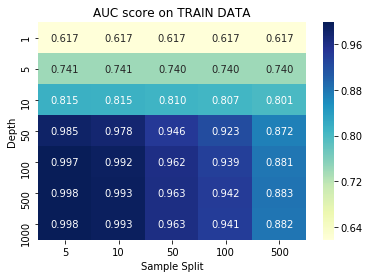

In [133]:
#Heatmap for AUC score of Train Data
AUC_BOW_Train = np.array(AUC_BOW_Train)
AUC_BOW_Train = AUC_BOW_Train.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_BOW_Train, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="YlGnBu")
plt.title("AUC score on TRAIN DATA")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

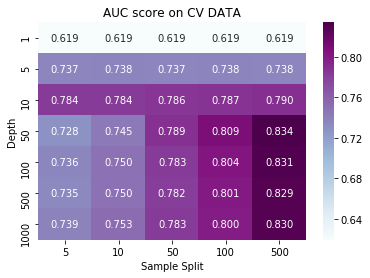

In [134]:
#Heatmap for AUC score of CV Data
AUC_BOW_CV = np.array(AUC_BOW_CV)
AUC_BOW_CV = AUC_BOW_CV.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_BOW_CV, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="BuPu")
plt.title("AUC score on CV DATA")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

In [135]:
# Creating ticks for x axis with each possible depth and split
depth = [1, 5, 10, 50, 100, 500, 1000]
split = [5, 10, 50, 100, 500] 
labels = []
for i in depth:
    for j in split:    
        temp = "depth = " + str(i)
        temp = temp + " & " + "split = " +str(j)
        labels.append(temp)
print(labels)

['depth = 1 & split = 5', 'depth = 1 & split = 10', 'depth = 1 & split = 50', 'depth = 1 & split = 100', 'depth = 1 & split = 500', 'depth = 5 & split = 5', 'depth = 5 & split = 10', 'depth = 5 & split = 50', 'depth = 5 & split = 100', 'depth = 5 & split = 500', 'depth = 10 & split = 5', 'depth = 10 & split = 10', 'depth = 10 & split = 50', 'depth = 10 & split = 100', 'depth = 10 & split = 500', 'depth = 50 & split = 5', 'depth = 50 & split = 10', 'depth = 50 & split = 50', 'depth = 50 & split = 100', 'depth = 50 & split = 500', 'depth = 100 & split = 5', 'depth = 100 & split = 10', 'depth = 100 & split = 50', 'depth = 100 & split = 100', 'depth = 100 & split = 500', 'depth = 500 & split = 5', 'depth = 500 & split = 10', 'depth = 500 & split = 50', 'depth = 500 & split = 100', 'depth = 500 & split = 500', 'depth = 1000 & split = 5', 'depth = 1000 & split = 10', 'depth = 1000 & split = 50', 'depth = 1000 & split = 100', 'depth = 1000 & split = 500']


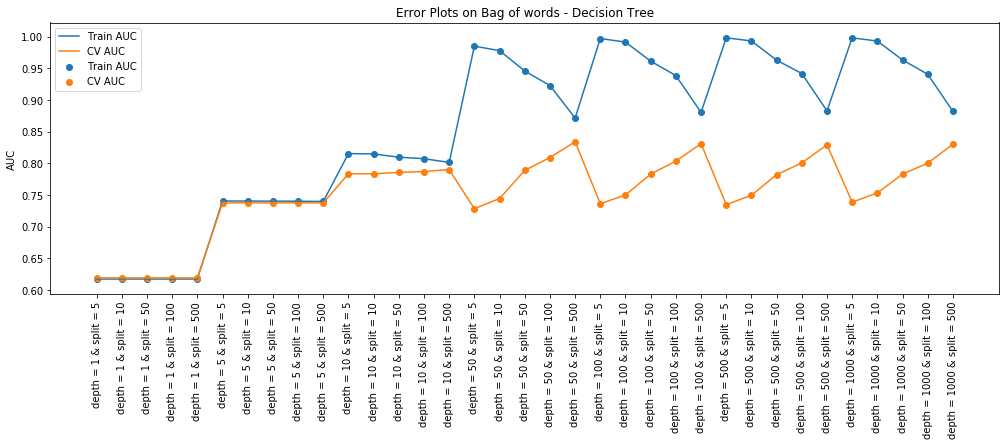

In [136]:
a1=AUC_BOW_Train.reshape(35,1)
a2=AUC_BOW_CV.reshape(35,1)

plt.figure(figsize=(17,5))
plt.plot(labels, a1, label='Train AUC')
plt.plot(labels, a2, label='CV AUC')

plt.scatter(labels, a1, label='Train AUC')
plt.scatter(labels, a2, label='CV AUC')

plt.legend()
plt.xticks(range(len(labels)), labels, rotation = 90)
plt.ylabel("AUC")
plt.title("Error Plots on Bag of words - Decision Tree")
plt.show()

In [137]:
#Decision Tree on test data with optimal depth = 50 and splits = 500
optimal = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
optimal.fit(xTrain_bow, yTrain)
predict_BOW_prob = optimal.predict_proba(xTest_bow)[:,1]
Train_predict_BOW = optimal.predict_proba(xTrain_bow)[:,1]
predict_BOW_class = optimal.predict(xTest_bow)
predict_testdata_BOW = optimal.predict(xTrain_bow)

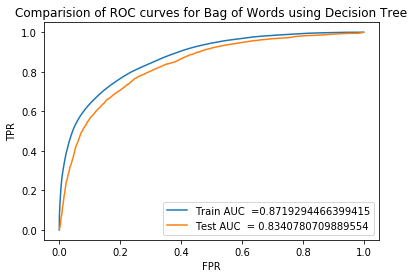

In [138]:
from sklearn.metrics import roc_curve, auc
Tr_FPR, Tr_TPR, tr = roc_curve(yTrain, Train_predict_BOW)
Te_FPR, Te_TPR, te = roc_curve(yTest, predict_BOW_prob)

plt.plot(Tr_FPR, Tr_TPR, label="Train AUC  ="+str(auc(Tr_FPR, Tr_TPR)))
plt.plot(Te_FPR, Te_TPR, label="Test AUC  = "+str(auc(Te_FPR, Te_TPR)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Bag of Words using Decision Tree")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

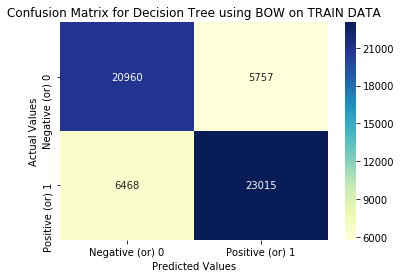

In [139]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_BOW)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Decision Tree using BOW on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

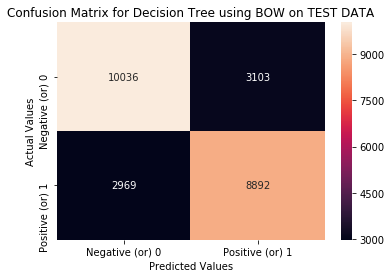

In [140]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_BOW_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Decision Tree using BOW on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


### Top 20 important features from<font color='red'> SET 1</font>

In [141]:
#source - https://datascience.stackexchange.com/questions/31406/tree-decisiontree-feature-importances-numbers-correspond-to-how-features
#Top 20 features
feat_names = count_vect.get_feature_names()
weights_bow = optimal.feature_importances_
df = pd.DataFrame(data = weights_bow, columns=['weight'], index=feat_names)
df.sort_values(by='weight', ascending=False, inplace=True)
print("Top 20 Features")
print(df.head(20))

Top 20 Features
                weight
not           0.173510
great         0.119068
best          0.065128
delicious     0.046644
perfect       0.036882
love          0.034545
disappointed  0.034203
good          0.033546
favorite      0.022885
loves         0.021603
bad           0.018708
excellent     0.018389
wonderful     0.016162
thought       0.014762
easy          0.014252
worst         0.014116
awful         0.013378
nice          0.012766
tasty         0.011637
horrible      0.011097


### Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

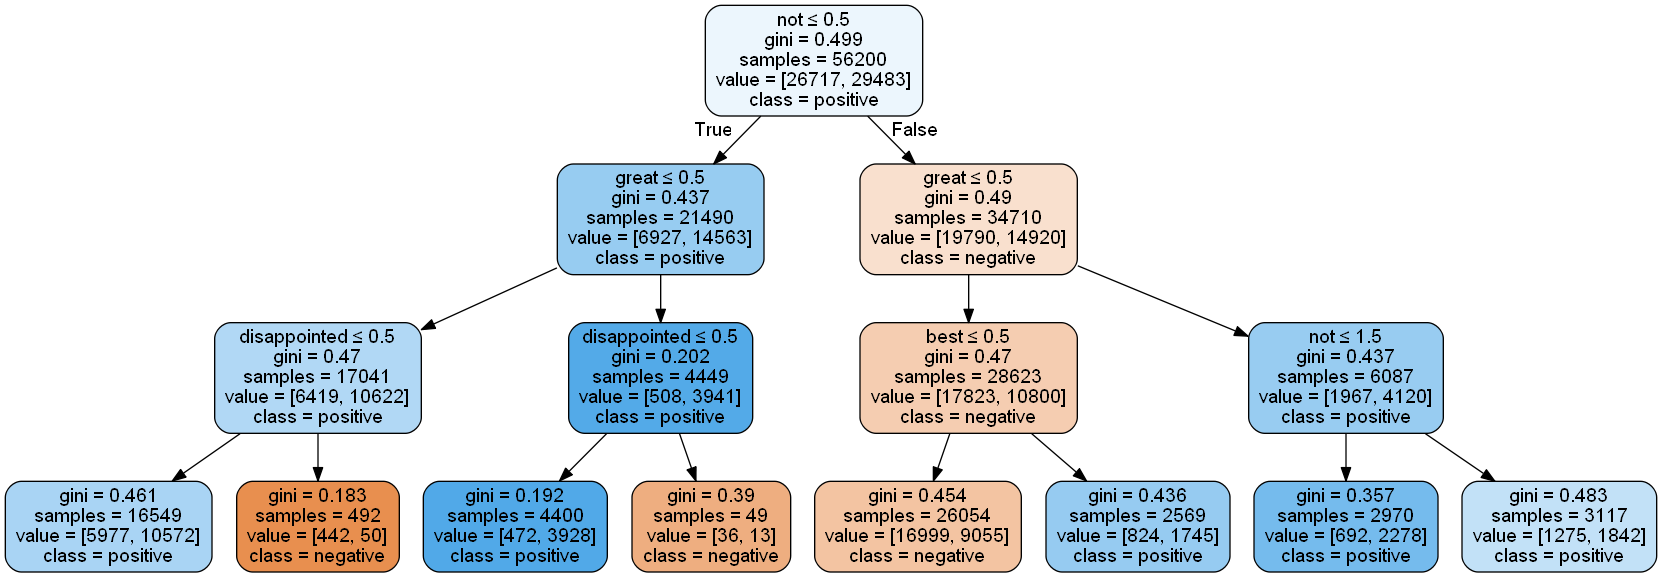

In [142]:
# Source - https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/
from graphviz import Source
import graphviz

viz = DecisionTreeClassifier(max_depth = 3)
viz.fit(xTrain_bow, yTrain)
pred = viz.predict(xTest_bow)

target = ['negative','positive']
data = tree.export_graphviz(viz,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True, feature_names=feat_names)

graph = pydotplus.graph_from_dot_data(data)  
Image(graph.create_png())

## Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [143]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(xTrain)
xTrain_tfidf=tf_idf_vect.transform(xTrain)
xCV_tfidf=tf_idf_vect.transform(xCV)
xTest_tfidf=tf_idf_vect.transform(xTest)
print("After transform")
print('='*100)
print(xTrain_tfidf.shape, yTrain.shape)
print(xCV_tfidf.shape, yCV.shape)
print(xTest_tfidf.shape, yTest.shape)

After transform
(56200, 500) (56200,)
(18800, 500) (18800,)
(25000, 500) (25000,)


In [144]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

depth = [1, 5, 10, 50, 100, 500, 1000]
split = [5, 10, 50, 100, 500] 

AUC_tfidf_Train = []
AUC_tfidf_CV = []


# Decision Tree on TF IDF
for i in tqdm(depth):
    for j in split:
        clf2 = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        clf2.fit(xTrain_tfidf, yTrain)

        #Predicting probability of positive class
        #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
        #we are slicing 2nd value
        Y_train_pred2 =  clf2.predict_proba(xTrain_tfidf)[:,1]
        Y_cv_pred2 =  clf2.predict_proba(xCV_tfidf)[:,1]
    
        #Calculation of ROC-AUC score on both train and-cross validate data
        AUC_tfidf_Train.append(roc_auc_score(yTrain,Y_train_pred2))
        AUC_tfidf_CV.append(roc_auc_score(yCV, Y_cv_pred2))



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:49<00:00, 90.82s/it]


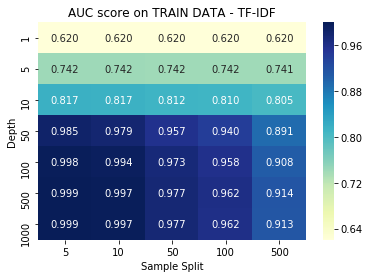

In [145]:
#Heatmap for AUC score of Train Data
AUC_tfidf_Train = np.array(AUC_tfidf_Train)
AUC_tfidf_Train = AUC_tfidf_Train.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_tfidf_Train, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="YlGnBu")
plt.title("AUC score on TRAIN DATA - TF-IDF")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

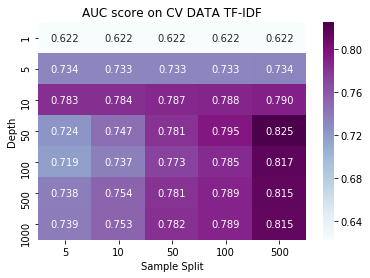

In [146]:
#Heatmap for AUC score of CV Data
AUC_tfidf_CV = np.array(AUC_tfidf_CV)
AUC_tfidf_CV = AUC_tfidf_CV.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_tfidf_CV, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="BuPu")
plt.title("AUC score on CV DATA TF-IDF")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

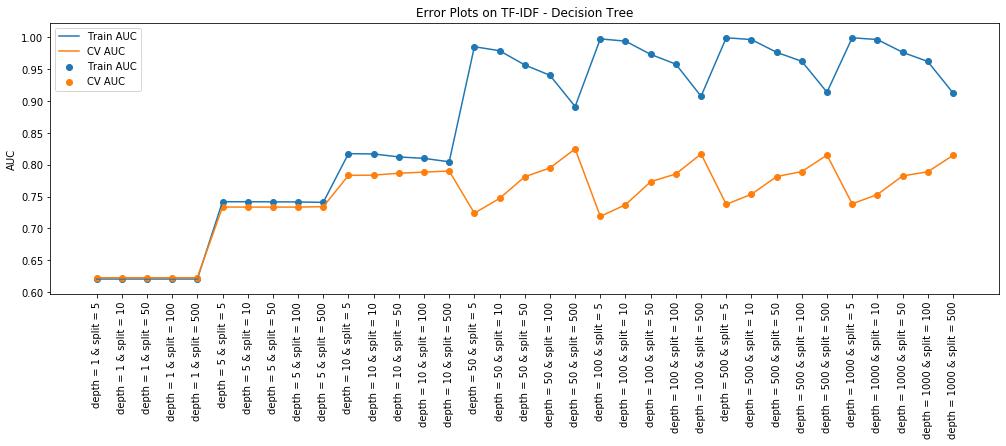

In [147]:

a1=AUC_tfidf_Train.reshape(35,1)
a2=AUC_tfidf_CV.reshape(35,1)

plt.figure(figsize=(17,5))
plt.plot(labels, a1, label='Train AUC')
plt.plot(labels, a2, label='CV AUC')

plt.scatter(labels, a1, label='Train AUC')
plt.scatter(labels, a2, label='CV AUC')

plt.legend()
plt.xticks(range(len(labels)), labels, rotation = 90)
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF - Decision Tree")
plt.show()


In [148]:
#Decision Tree on test data with optimal depth = 50 and splits = 500
optimal_l1_tf = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
optimal_l1_tf.fit(xTrain_tfidf, yTrain)
predict_tfidf_prob = optimal_l1_tf.predict_proba(xTest_tfidf)[:,1]
Train_predict_tfidf = optimal_l1_tf.predict_proba(xTrain_tfidf)[:,1]
predict_tfidf_class = optimal_l1_tf.predict(xTest_tfidf)
predict_testdata_TFIDF = optimal_l1_tf.predict(xTrain_tfidf)


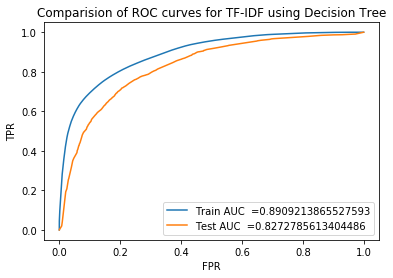

In [149]:
from sklearn.metrics import roc_curve, auc
Tr_FPR2, Tr_TPR2, tr2 = roc_curve(yTrain, Train_predict_tfidf)
Te_FPR2, Te_TPR2, te2 = roc_curve(yTest, predict_tfidf_prob)

plt.plot(Tr_FPR2, Tr_TPR2, label="Train AUC  ="+str(auc(Tr_FPR2, Tr_TPR2)))
plt.plot(Te_FPR2, Te_TPR2, label="Test AUC  ="+str(auc(Te_FPR2, Te_TPR2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF using Decision Tree")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

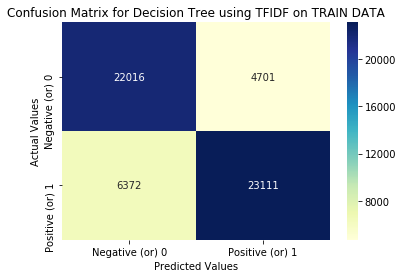

In [150]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_TFIDF)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Decision Tree using TFIDF on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

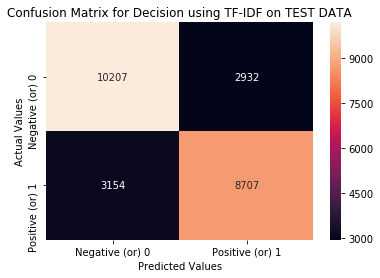

In [151]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidf_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Decision using TF-IDF on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

### Top 20 important features from<font color='red'> SET 2</font>

In [152]:
#source - https://datascience.stackexchange.com/questions/31406/tree-decisiontree-feature-importances-numbers-correspond-to-how-features
#Top 20 features
fe = tf_idf_vect.get_feature_names()
weights_tfidf = optimal_l1_tf.feature_importances_
df = pd.DataFrame(data = weights_tfidf, columns=['weight'], index=fe)
df.sort_values(by='weight', ascending=False, inplace=True)
print("Top 20 Features")
print(df.head(20))

Top 20 Features
                weight
not           0.142153
great         0.105071
best          0.057889
delicious     0.040578
disappointed  0.034475
perfect       0.032521
good          0.031724
love          0.030900
loves         0.020491
favorite      0.019623
thought       0.016783
bad           0.016577
excellent     0.016104
worst         0.014801
wonderful     0.013675
awful         0.013193
nice          0.012549
not good      0.012442
horrible      0.010770
easy          0.010644


### Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

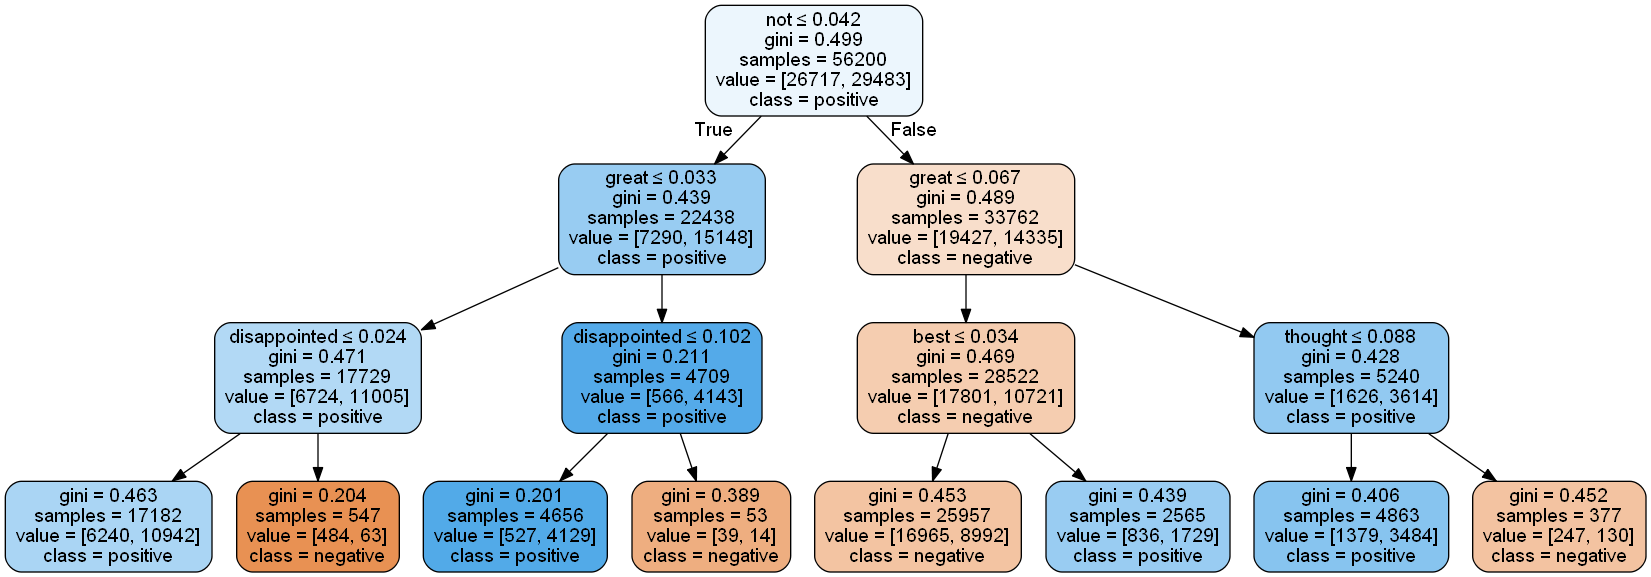

In [153]:
# Source - https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/
from graphviz import Source
import graphviz

viz2 = DecisionTreeClassifier(max_depth = 3)
viz2.fit(xTrain_tfidf, yTrain)
pred = viz2.predict(xTest_tfidf)

target = ['negative','positive']
data2 = tree.export_graphviz(viz2,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True, feature_names=fe)

graph = pydotplus.graph_from_dot_data(data2)  
Image(graph.create_png())

## Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>


In [154]:
# Train your own Word2Vec model using your own text corpus
#-------------------TRAIN DATA----------------#
i=0
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
    
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14846
sample words  ['remember', 'seeing', 'show', 'aired', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'children', 'tradition', 'lives', 'always', 'enjoyed', 'movie', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'eliminated', 'strong', 'elements', 'usually', 'edited', 'version', 'warned', 'want']


In [155]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 56200/56200 [03:16<00:00, 301.59it/s]


56200
50


In [156]:
# Train your own Word2Vec model using your own text corpus
#-------------------CROSS-VALIDATION DATA----------------#
i=0
list_of_sentance_cv=[]
for sentance in xCV:
    list_of_sentance_cv.append(sentance.split())
    

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 18800/18800 [01:08<00:00, 273.38it/s]


18800
50


In [157]:
# Train your own Word2Vec model using your own text corpus
#-------------------TEST DATA----------------#
i=0
list_of_sentance_test=[]
for sentance in xTest:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:33<00:00, 266.51it/s]


25000
50


In [158]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

depth = [1, 5, 10, 50, 100, 500, 1000]
split = [5, 10, 50, 100, 500] 

AUC_aw2v_Train = []
AUC_aw2v_CV = []

# Decision Tree on W2V
for i in tqdm(depth):
    for j in split:
        clf3 = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        clf3.fit(sent_vectors_train, yTrain)

        #Predicting probability of positive class
        #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
        #we are slicing 2nd value    
        Y_train_pred3 =  clf3.predict_proba(sent_vectors_train)[:,1]
        Y_cv_pred3 =  clf3.predict_proba(sent_vectors_cv)[:,1]
    
        #Calculation of ROC-AUC score on both train and-cross validate data    
        AUC_aw2v_Train.append(roc_auc_score(yTrain,Y_train_pred3))
        AUC_aw2v_CV.append(roc_auc_score(yCV, Y_cv_pred3))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 21.35s/it]


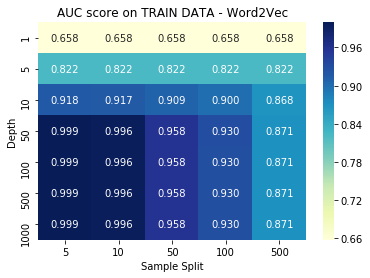

In [159]:
#Heatmap for AUC score of Train Data
AUC_aw2v_Train = np.array(AUC_aw2v_Train)
AUC_aw2v_Train = AUC_aw2v_Train.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_aw2v_Train, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="YlGnBu")
plt.title("AUC score on TRAIN DATA - Word2Vec")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

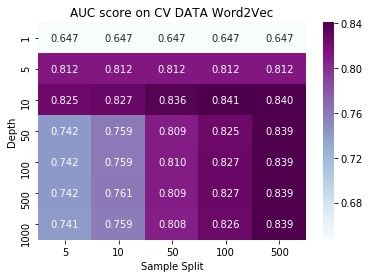

In [160]:
#Heatmap for AUC score of CV Data
AUC_aw2v_CV = np.array(AUC_aw2v_CV)
AUC_aw2v_CV = AUC_aw2v_CV.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_aw2v_CV, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="BuPu")
plt.title("AUC score on CV DATA Word2Vec")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

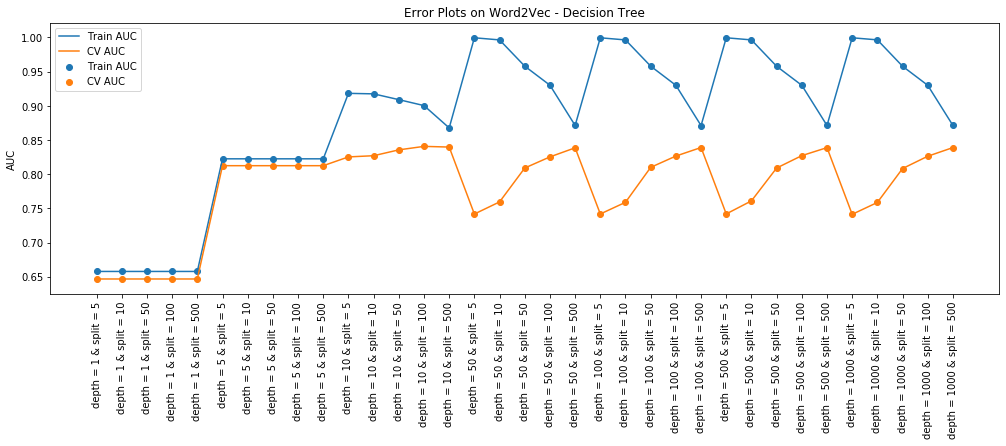

In [161]:
a1=AUC_aw2v_Train.reshape(35,1)
a2=AUC_aw2v_CV.reshape(35,1)

plt.figure(figsize=(17,5))
plt.plot(labels, a1, label='Train AUC')
plt.plot(labels, a2, label='CV AUC')

plt.scatter(labels, a1, label='Train AUC')
plt.scatter(labels, a2, label='CV AUC')

plt.legend()
plt.xticks(range(len(labels)), labels, rotation = 90)
plt.ylabel("AUC")
plt.title("Error Plots on Word2Vec - Decision Tree")
plt.show()

In [162]:
#Decision Tree on test data with optimal depth = 10 and splits = 500
optimal_l1_w2v = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)
optimal_l1_w2v.fit(sent_vectors_train, yTrain)
Train_predict_aw2v = optimal_l1_w2v.predict_proba(sent_vectors_train)[:,1]
predict_aw2v_prob = optimal_l1_w2v.predict_proba(sent_vectors_test)[:,1]
predict_aw2v_class = optimal_l1_w2v.predict(sent_vectors_test)
predict_testdata_W2V = optimal_l1_w2v.predict(sent_vectors_train)


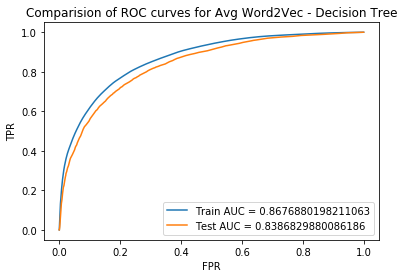

In [172]:
Tr_FPR3, Tr_TPR3, tr3 = roc_curve(yTrain, Train_predict_aw2v)
Te_FPR3, Te_TPR3, te3 = roc_curve(yTest, predict_aw2v_prob)

plt.plot(Tr_FPR3, Tr_TPR3, label="Train AUC = "+str(auc(Tr_FPR3, Tr_TPR3)))
plt.plot(Te_FPR3, Te_TPR3, label="Test AUC = "+str(auc(Te_FPR3, Te_TPR3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for Avg Word2Vec - Decision Tree")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

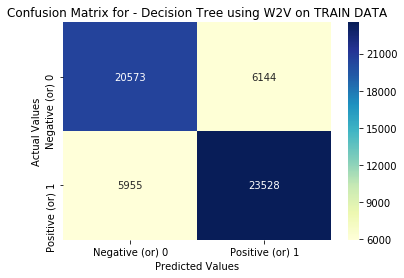

In [173]:

# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_W2V)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for - Decision Tree using W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

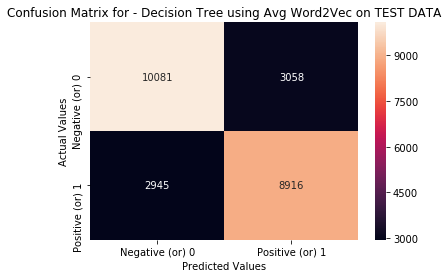

In [174]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_aw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for - Decision Tree using Avg Word2Vec on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

##  Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [166]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(xTrain)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [167]:
#------------------------TF-IDF Word2Vec----------------
#-------------------------TRAIN DATA--------------------
i=0
list_of_sentance_train=[]
for sentance in xTrain:
    list_of_sentance_train.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 56200/56200 [1:01:48<00:00, 15.15it/s]


In [168]:
#------------------------TF-IDF Word2Vec----------------
#---------------------CROSS VALIDATION DATA--------------------
i=0
list_of_sentance_cv=[]
for sentance in xCV:
    list_of_sentance_cv.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18800/18800 [12:59<00:00, 24.13it/s]


In [169]:
#------------------------TF-IDF Word2Vec----------------
#-------------------------Test DATA--------------------
i=0
list_of_sentance_test=[]
for sentance in xTest:
    list_of_sentance_test.append(sentance.split())
    
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# XXfinal_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [16:48<00:00, 24.79it/s]


In [171]:
# Please write all the code with proper documentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

depth = [1, 5, 10, 50, 100, 500, 1000]
split = [5, 10, 50, 100, 500] 

AUC_tfidfw2v_Train = []
AUC_tfidfw2v_CV = []

# Decision Tree on TFIDF W2V
for i in tqdm(depth):
    for j in split:
        clf4 = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        clf4.fit(tfidf_sent_vectors_train, yTrain)

        #Predicting probability of positive class
        #here predict_proba outputs 2 values: 1st-probability of getting class 0, 2nd-probability of getting class 1
        #we are slicing 2nd value    
        Y_train_pred4 =  clf4.predict_proba(tfidf_sent_vectors_train)[:,1]
        Y_cv_pred4 =  clf4.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
        #Calculation of ROC-AUC score on both train and-cross validate data    
        AUC_tfidfw2v_Train.append(roc_auc_score(yTrain,Y_train_pred4))
        AUC_tfidfw2v_CV.append(roc_auc_score(yCV, Y_cv_pred4))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:41<00:00, 26.42s/it]


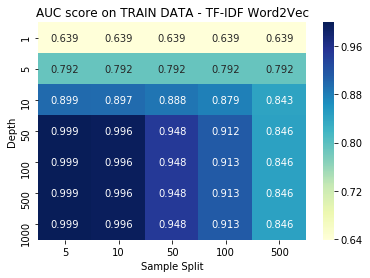

In [175]:
#Heatmap for AUC score of Train Data
AUC_tfidfw2v_Train = np.array(AUC_tfidfw2v_Train)
AUC_tfidfw2v_Train = AUC_tfidfw2v_Train.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_tfidfw2v_Train, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="YlGnBu")
plt.title("AUC score on TRAIN DATA - TF-IDF Word2Vec")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

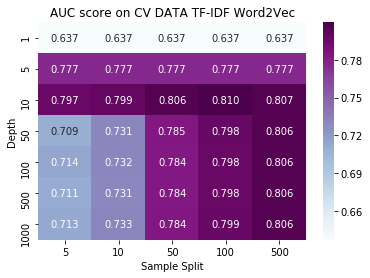

In [176]:
#Heatmap for AUC score of CV Data
AUC_tfidfw2v_CV = np.array(AUC_tfidfw2v_CV)
AUC_tfidfw2v_CV = AUC_tfidfw2v_CV.reshape(len(depth),len(split))
matrix = pd.DataFrame(AUC_tfidfw2v_CV, index=depth, columns=split)
sns.heatmap(matrix, annot=True, fmt='.3f', cmap="BuPu")
plt.title("AUC score on CV DATA TF-IDF Word2Vec")
plt.xlabel('Sample Split')
plt.ylabel('Depth')
plt.show()

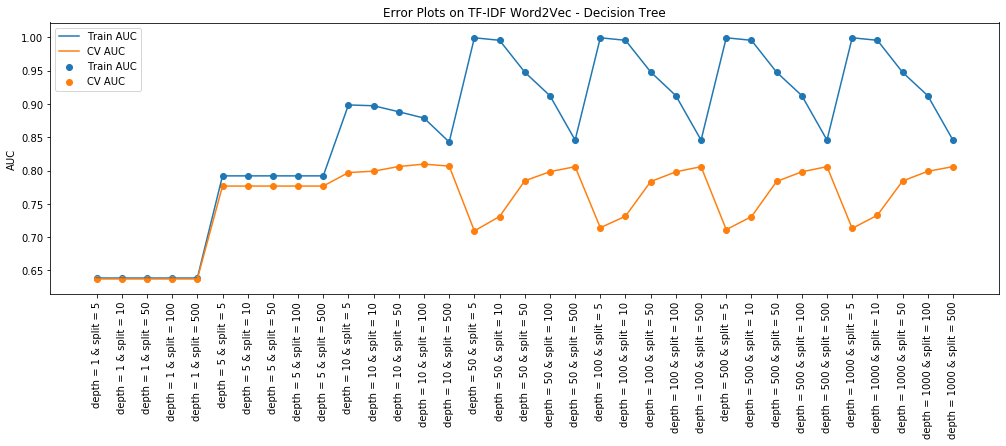

In [177]:
a1=AUC_tfidfw2v_Train.reshape(35,1)
a2=AUC_tfidfw2v_CV.reshape(35,1)

plt.figure(figsize=(17,5))
plt.plot(labels, a1, label='Train AUC')
plt.plot(labels, a2, label='CV AUC')

plt.scatter(labels, a1, label='Train AUC')
plt.scatter(labels, a2, label='CV AUC')

plt.legend()
plt.xticks(range(len(labels)), labels, rotation = 90)
plt.ylabel("AUC")
plt.title("Error Plots on TF-IDF Word2Vec - Decision Tree")
plt.show()

In [178]:
#Decision Tree on test data with optimal depth = 10 and splits = 500
optimal_l1_at = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)
optimal_l1_at.fit(tfidf_sent_vectors_train, yTrain)
Train_predict_tfidfw2v = optimal_l1_at.predict_proba(tfidf_sent_vectors_train)[:,1]
predict_tfidfw2v_prob = optimal_l1_at.predict_proba(tfidf_sent_vectors_test)[:,1]
predict_tfidfw2v_class = optimal_l1_at.predict(tfidf_sent_vectors_test)
predict_testdata_at = optimal_l1_at.predict(tfidf_sent_vectors_train)


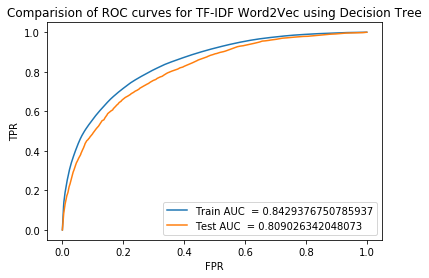

In [179]:
Tr_FPR4, Tr_TPR4, tr4 = roc_curve(yTrain, Train_predict_tfidfw2v)
Te_FPR4, Te_TPR4, te4 = roc_curve(yTest, predict_tfidfw2v_prob)

plt.plot(Tr_FPR4, Tr_TPR4, label="Train AUC  = "+str(auc(Tr_FPR4, Tr_TPR4)))
plt.plot(Te_FPR4, Te_TPR4, label="Test AUC  = "+str(auc(Te_FPR4, Te_TPR4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparision of ROC curves for TF-IDF Word2Vec using Decision Tree")
plt.show()

Text(32.99999999999999, 0.5, 'Actual Values')

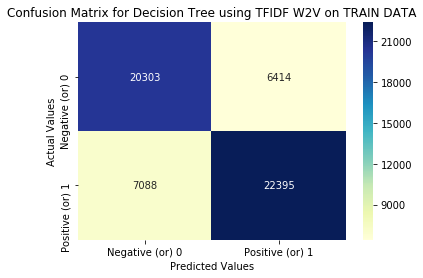

In [180]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTrain, predict_testdata_at)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix for Decision Tree using TFIDF W2V on TRAIN DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


Text(32.99999999999999, 0.5, 'Actual Values')

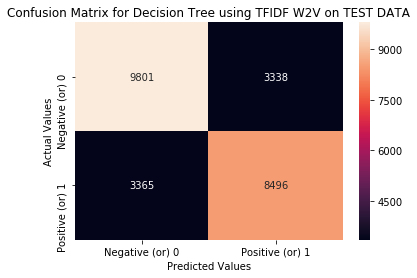

In [181]:
# source for heat map: https://stackoverflow.com/a/37790707
conf_matrix = confusion_matrix(yTest, predict_tfidfw2v_class)
class_label = ["Negative (or) 0" , "Positive (or) 1"]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Decision Tree using TFIDF W2V on TEST DATA")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# Conclusion

In [182]:
from prettytable import PrettyTable    
x = PrettyTable()

x.field_names = ["Vectorizer", "Optimal depth", "Optimal min_split", "Test AUC"]

x.add_row(["Bag of Words", 50, 500, 0.834])
x.add_row(["TF-IDF", 50, 500, 0.827])
x.add_row(["Avg W2V", 10, 500, 0.838])
x.add_row(["TF-IDF W2V", 10, 500, 0.809])

print(x)

+--------------+---------------+-------------------+----------+
|  Vectorizer  | Optimal depth | Optimal min_split | Test AUC |
+--------------+---------------+-------------------+----------+
| Bag of Words |       50      |        500        |  0.834   |
|    TF-IDF    |       50      |        500        |  0.827   |
|   Avg W2V    |       10      |        500        |  0.838   |
|  TF-IDF W2V  |       10      |        500        |  0.809   |
+--------------+---------------+-------------------+----------+
